In [1]:
import torch 
import torchvision
from torch import nn, optim
from torchvision import transforms
from torch.nn import functional as F

import math
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from typing import List

In [2]:
class Normalization(nn.Module):
    
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        ## C,1,1 shape for broadcasting
        self.mean = torch.tensor(mean).view(-1, 1, 1).to(device)
        self.std = torch.tensor(std).view(-1, 1, 1).to(device)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [3]:
class customloss(nn.Module):
    
    def __init__(self):
        super(customloss, self).__init__()
        self.style_layer = style_layer
        self.unfold = nn.Unfold(3)
    
    def styleloss(self, s, i):
        s_patch = self.patchify(s)
        i_patch = self.patchify(i)
        
        knn = self.find_nn(s_patch, i_patch)
        
        # only style and output compared
        return F.mse_loss(i_patch[:(i.shape[1]-3)*3*3,:], s_patch[:(s.shape[1]-3)*3*3,knn])
    
    def total_variation_loss(self, x):
        # only output computed, no semantic map
        # tv is calculated loss to right and down
        return (((x[:,(x.shape[1]-3),:-1,:-1] - x[:,(x.shape[1]-3),1:,:-1])**2 + (x[:,(x.shape[1]-3),:-1,:-1] - x[:,(x.shape[1]-3),:-1,1:])**2)**1.25).mean()
    
    def patchify(self, x):
        return self.unfold(x).squeeze()
    
    def find_nn(self, s, i):
        
        i_norm = i/i.norm(p=2,dim=0)
        s_norm = s/s.norm(p=2,dim=0)

        similarity_matrix = i_norm.t() @ s_norm        
        nearest_neighbours = similarity_matrix.argmax(dim=1)
        
        return nearest_neighbours
        
    def forward(self, smap: List[torch.Tensor], imap: List[torch.Tensor]):
        style_loss = 0
        tv_loss = 0
        
        for s,i in zip(smap,imap): style_loss += self.styleloss(s, i)
        for i in imap: tv_loss += self.total_variation_loss(i)
                
        return style_loss, tv_loss

In [4]:
def run_synthesize(model, style_img, style_map, input_map):
    """Run the style transfer."""
            
    _, _, h, w = style_img.shape
    
    for i in range(phases):
        if i > 0:
            break
        
        # scale = 1.0 / 2.0 ** (phases - i - 1)
        scale = 1 / 2
        re_h, re_w = int(h*scale), int(w*scale)

        _style_img = transforms.Resize((re_h,re_w))(style_img)
        _style_map = transforms.Resize((re_h,re_w))(style_map)
        _input_map = transforms.Resize((re_h,re_w))(input_map)
#         _output_img = transforms.Resize((re_h,re_w))(output_img)
    
        output_img = torch.rand_like(_style_img).to(device)    
    
        optimizer = optim.LBFGS([output_img.requires_grad_()])
    
        for i in range(num_steps+1):

            output_img.data.clip_(0,1)
            
            optimizer.zero_grad()

            s_feature, s_map = model(_style_img, _style_map)
            i_feature, i_map = model(output_img, _input_map)
            
            style_score, tv_score = criterion(s_map, i_map)

            loss = style_weight * style_score + smoothness * tv_score
            loss.backward()

            loss_val = optimizer.step(lambda: loss)
            

            if (i % 50) == 0: print(f'{i : < 6} {loss_val.item()}')
        
        output_img.data.clip_(0,1)

    return output_img

# setting

In [5]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

In [6]:
device = 'cuda:0'

In [7]:
style_layer = ['3_1','4_1']
content_layer = ['4_2']

In [8]:
content_weight = 10
style_weight = 25
# semantic_weight_ori = 10
smoothness = 1
user_control_weight = 50
phases = 3
num_steps = 300

In [9]:
# semantic_weight = math.sqrt(9/semantic_weight_ori)

# model

In [10]:
cnn = torchvision.models.vgg19(pretrained=True).features.to(device).eval()

In [11]:
class Aux_Network(nn.Module):
    
    def __init__(self):
        super(Aux_Network, self).__init__()
        self.normalization = Normalization(IMAGENET_MEAN,IMAGENET_STD)
        self.feature_extractor = cnn
#         self.neighber_conv = [nn.Conv2d(i+3,3,3,bias=False).to(device) for i in [256,512]]
        
    def forward(self, img, mapping):
        block_num, conv_num = 0, 0
        conv_list = []
        aux_list = []
        
        img = self.normalization(img)
        
        for l in self.feature_extractor:
            img = l(img)
            if isinstance(l, nn.ReLU):
                conv_num += 1
                layer_name = f'{block_num+1}_{conv_num}'
                if layer_name in style_layer:
                    conv_list.append(img)
                    aux_list.append(torch.cat([img, user_control_weight*F.avg_pool2d(mapping,2**block_num)*img.shape[1]],dim=1))
            elif isinstance(l, nn.MaxPool2d):
                block_num += 1
                conv_num = 0
        
#         for a,c in zip(aux_list,self.neighber_conv):
#             a = c(a)
        
        return conv_list, aux_list

In [12]:
model = Aux_Network()

In [13]:
# test_case = model(torch.rand(1,3,224,224).cuda(),torch.rand(1,3,224,224).cuda())

In [14]:
criterion = customloss()

In [15]:
# criterion(test_case[1],test_case[1])

In [16]:
# torch.onnx.export(model,(torch.rand(1,3,224,224).cuda(),torch.rand(1,3,224,224).cuda()),'a.onnx')

# start transfer

In [17]:
ToTensor = transforms.Compose([
  transforms.ToTensor()  
])

In [18]:
style_img = ToTensor(Image.open('forest.jpg')).unsqueeze(0).to(device)
style_map = ToTensor(Image.open('map.png')).unsqueeze(0).to(device)
input_map = ToTensor(Image.open('output.jpg')).unsqueeze(0).to(device)

In [19]:
output = run_synthesize(model, style_img, style_map, input_map)

C:\Users\User\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


 0     1201751808.0
 50    1201750784.0
 100   1201750784.0
 150   1201750784.0
 200   1201750784.0
 250   1201750784.0
 300   1201750784.0


# visualize

In [20]:
def tensor_to_np(tensor):
    return tensor.permute(0,2,3,1).squeeze(0).detach().cpu().numpy() 

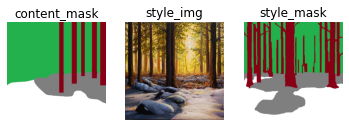

In [21]:
plt.subplot(1,3,1)
plt.title('content_mask')
plt.axis('off')
plt.imshow(tensor_to_np(input_map))
plt.subplot(1,3,2)
plt.title('style_img')
plt.axis('off')
plt.imshow(tensor_to_np(style_img))
plt.subplot(1,3,3)
plt.title('style_mask')
plt.axis('off')
plt.imshow(tensor_to_np(style_map))

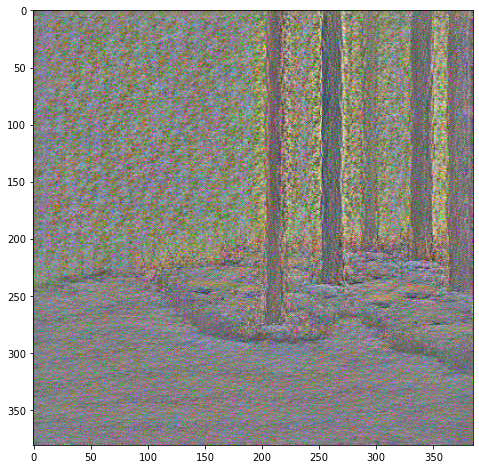

In [22]:
output_post = output.permute(0,2,3,1).squeeze(0).detach().cpu().numpy()

plt.figure(figsize=(8,8))
plt.imshow(output_post)

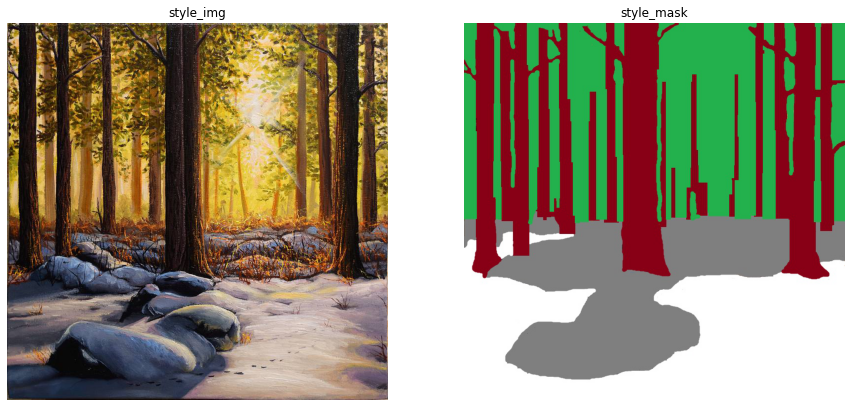

In [25]:
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.title('style_img')
plt.axis('off')
plt.imshow(tensor_to_np(style_img))
plt.subplot(1,2,2)
plt.title('style_mask')
plt.axis('off')
plt.imshow(tensor_to_np(style_map))

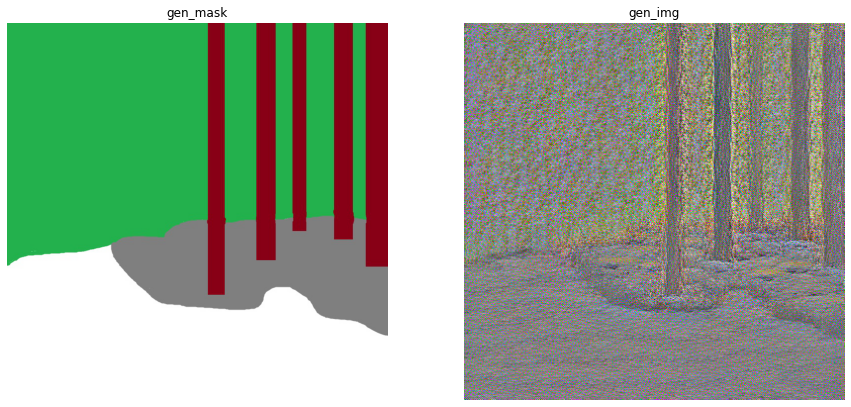

In [28]:
fig = plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.title('gen_mask')
plt.axis('off')
plt.imshow(tensor_to_np(input_map))
plt.subplot(1,2,2)
plt.title('gen_img')
plt.axis('off')
plt.imshow(output_post)
# fig.savefig('doc2.jpg')